# Data Collection

### Importing required libraries

In [85]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


### Getting the list of stations from Wikipedia

In [53]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Mumbai_Suburban_Railway_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'lxml')

# get the table containing the postal codes
stations_table = wiki_doc.findAll('table')[1]

### Adding location data and making a dataframe

In [95]:
stations_df = pd.DataFrame(columns=['Station Name','Line','Latitude','Longitude'])

for tr in stations_table.find_all('tr')[2:]:
    #line = re.search('#(.+?)\s', tr.find('a')['title']).group(1)
    station_name=tr.find('a')['title']
    line=tr.find_all('td')[4].find('a')['title']
    line=line.split('(',1)[0]
    geolocator = Nominatim(timeout=10)
    location = geolocator.geocode(station_name)
    if(location != None):
        latitude=location.latitude
        longitude=location.longitude
    else:
        latitude=None
        longitude=None

    stations_df = stations_df.append({'Station Name':station_name,'Line':line,'Latitude':latitude,'Longitude':longitude}, ignore_index=True)  
stations_df.to_csv('stations.csv')

c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [97]:
stations_df.head()

,Station Name,Line,Latitude,Longitude
0,Airoli railway station,Trans-Harbour Line,19.159246,72.998512
1,Ambarnath railway station,Central Line,19.094332,73.300895
2,Ambivli railway station,Central Line,19.267645,73.171863
3,Andheri railway station,Western Line,19.119698,72.846420
4,Asangaon railway station,Central Line,19.440912,73.306518


# Data Cleaning and Preparation

In [98]:
stations_df.isna().sum()

Station Name    0
Line            0
Latitude        3
Longitude       3
dtype: int64

In [99]:
# Removing the stations where geopy couldn't find the coordinates.
stations_df=stations_df.dropna()

In [104]:
stations_df['Line'].unique()

array(['Trans-Harbour Line ', 'Central Line ', 'Western Line ',
       'Harbour Line ', 'Nerul–Uran line ', 'Harbour Line'], dtype=object)

In [115]:
stations_df['Line'].replace({'Harbour Line ':'Harbour Line'},inplace=True)

### Plotting a folium map with all the stationsclustered by the lines they serve

In [144]:
# Line color codes
line_colors = {
    'Trans-Harbour Line ':'#EF161E',
    'Central Line ':'#2DBE2C',
    'Western Line ':'#0078BE',
    'Harbour Line':'#DE64A1',
    'Nerul–Uran line ':'#8D5B2D'}
for latitude, longitude, line, station_name in zip(stations_df['Latitude'], stations_df['Longitude'], stations_df['Line'],stations_df['Station Name']):
    label = folium.Popup(station_name, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=line_colors[line],
        fill_opacity=0.7).add_to(rail_map)  

In [145]:
rail_map

In [146]:
rail_map.save('Mumbai.html')

## Venues and categories

In [148]:
CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5'
CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR'
VERSION = '20181020'

We will use Foursquare API to explore venue categories surrounding each station. Venues can be categorized as residential, professional, shopping or leisure. Let's see what venue categories Foursquare identifies.

In [150]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


### For each station we will count the number of venues in each of the top 10 categories. 

In [181]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    #print(requests.get(explore_url).json())
    try:
        totalResults=requests.get(explore_url).json()['response']['totalResults']
    except:
        totalResults=0
    #return requests.get(explore_url).json()['response']['totalResults']
    return totalResults

In [176]:
#Create new dataframe to store venues data
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

### Creating a dataframe with the stations and the number of venues on top 10 categories.

In [183]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    print(i)
    for c in categories_list:      
        coordinates=str(stations_venues_df.Latitude.iloc[i])+','+str(stations_venues_df.Longitude.iloc[i])
        stations_venues_df.loc[i, c[0]] = get_venues_count(coordinates, radius=1000, categoryId=c[1])
#stations_venues_df.to_csv('stations_venues.csv')

0
1
2
3
4
5
6
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
90
91
92
93
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


IndexError: single positional indexer is out-of-bounds

In [185]:
stations_venues_df.to_csv('StationVenues.csv')

In [186]:
stations_venues_df.head()

,Station Name,Line,Latitude,Longitude,Cluster,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Airoli railway station,Trans-Harbour Line,19.159246,72.998512,0,0,5,0,12,2,8,15,4,3,5
1,Ambarnath railway station,Central Line,19.094332,73.300895,0,0,0,0,0,0,2,1,0,1,1
2,Ambivli railway station,Central Line,19.267645,73.171863,0,0,0,0,1,0,0,2,1,3,4
3,Andheri railway station,Western Line,19.119698,72.846420,0,5,8,0,29,7,9,33,4,36,15
4,Asangaon railway station,Central Line,19.440912,73.306518,0,0,0,0,6,0,0,0,0,0,1


### Visualizing to see how the venues compare to each other

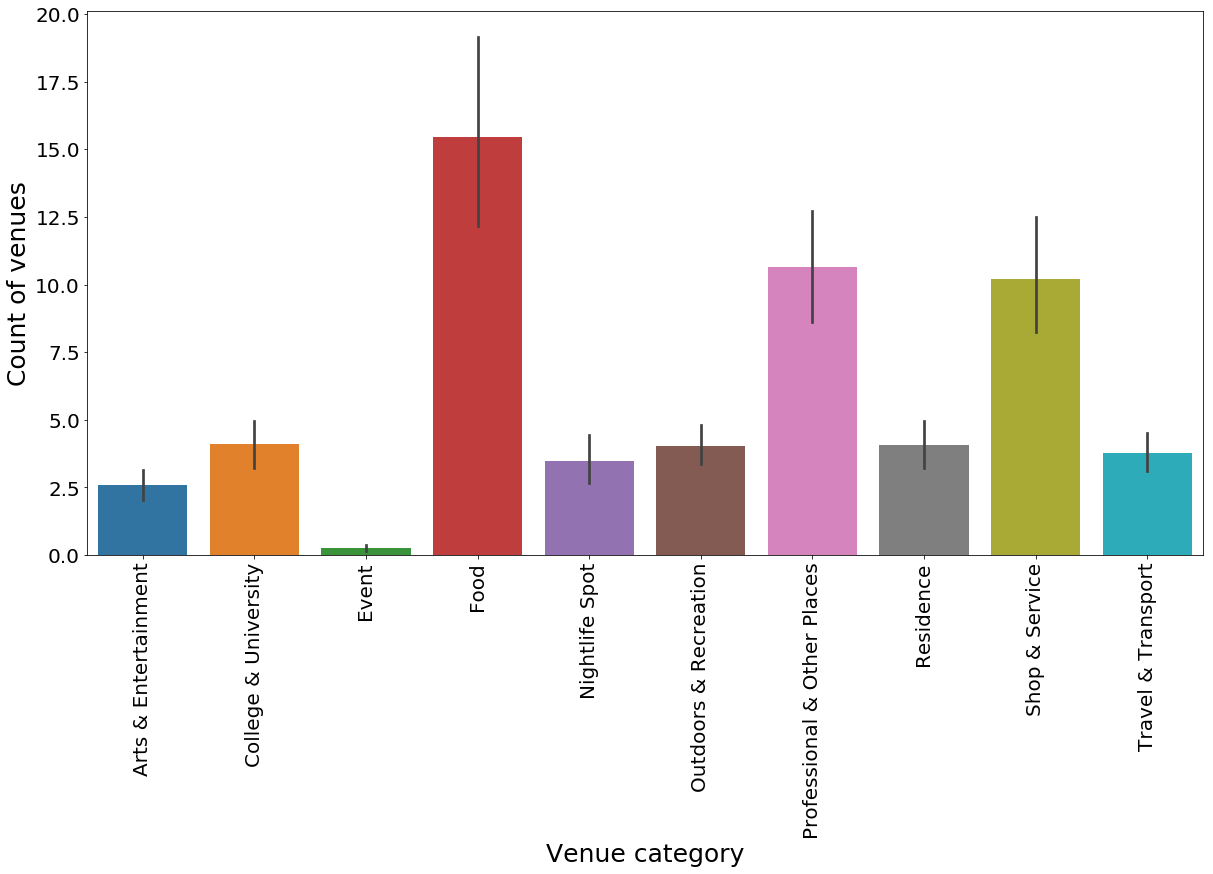

In [189]:
venues=stations_venues_df.drop(columns=['Latitude','Longitude','Cluster'])
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.barplot(data = venues)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.show()

We'll use K-means clustering to see how do the stations cluster. For easy interpretation we'll take 4 clusters. 

In [251]:
# set number of clusters
kclusters = 4
X = stations_venues_df.values[:,4:]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_ = stations_venues_df.copy()
stations_clusters_['Cluster'] = kmeans_labels

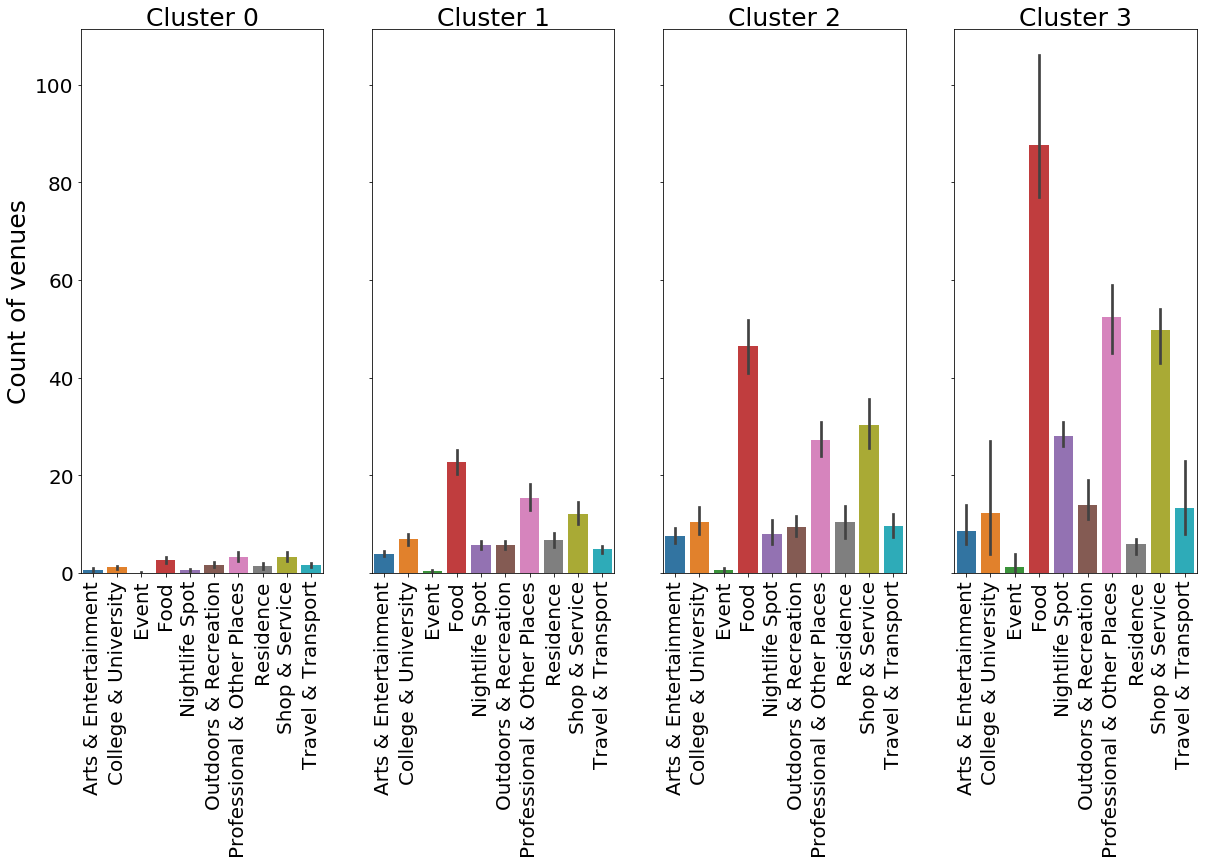

In [253]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    #axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.barplot(data = stations_clusters_[stations_clusters_['Cluster'] == k].drop(['Latitude','Longitude','Cluster'],1), ax=axes[k])

plt.show()

### And now we'll plot the stations on Folium again. But this time, they'll be colorized on the basis of which cluster they come under. 

In [ ]:
stations_clusters_
stations_clusters_=stations_clusters_.dropna()
stations_clusters_=stations_clusters_.reset_index()
#create map of Mumbai with all stations
mumbai_rail_map = folium.Map(location=[19.0760, 72.8777], zoom_start=10)

#add markers
for i, station, latitude,longitude, cluster in zip(stations_clusters_.index,
                                         stations_clusters_['Station Name'],
                                         stations_clusters_['Latitude'],stations_clusters_minmax_df['Longitude'],
                                         stations_clusters_['Cluster']):
    colors=['blue','green','black','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker([latitude, longitude],fill=True,fill_opacity=0.5,popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster],
        fill_color=colors[cluster]
    ).add_to(mumbai_rail_map)
    

In [255]:
mumbai_rail_map

In [256]:
mumbai_rail_map.save('mumbai_rail_map.html')

### We can also try to do the above steps by normalizing the counts of each venue category

Since a lot of people around Mumbai don't really seem to enjoy Events, let's just drop it 

In [190]:
venues.drop('Event', 1, inplace=True)

In [191]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

We'll use the min max scaler to normalize the values

In [200]:
from sklearn.preprocessing import MinMaxScaler

X = venues.values[:,2:]
cluster_dataset = MinMaxScaler().fit_transform(X)

In [201]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.000000,0.185185,0.113208,0.064516,0.421053,0.254237,0.137931,0.053571,0.217391
1,0.000000,0.000000,0.000000,0.000000,0.105263,0.016949,0.000000,0.017857,0.043478
2,0.000000,0.000000,0.009434,0.000000,0.000000,0.033898,0.034483,0.053571,0.173913
3,0.333333,0.296296,0.273585,0.225806,0.473684,0.559322,0.137931,0.642857,0.652174
4,0.000000,0.000000,0.056604,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478


Let's see how the venues look like now

c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


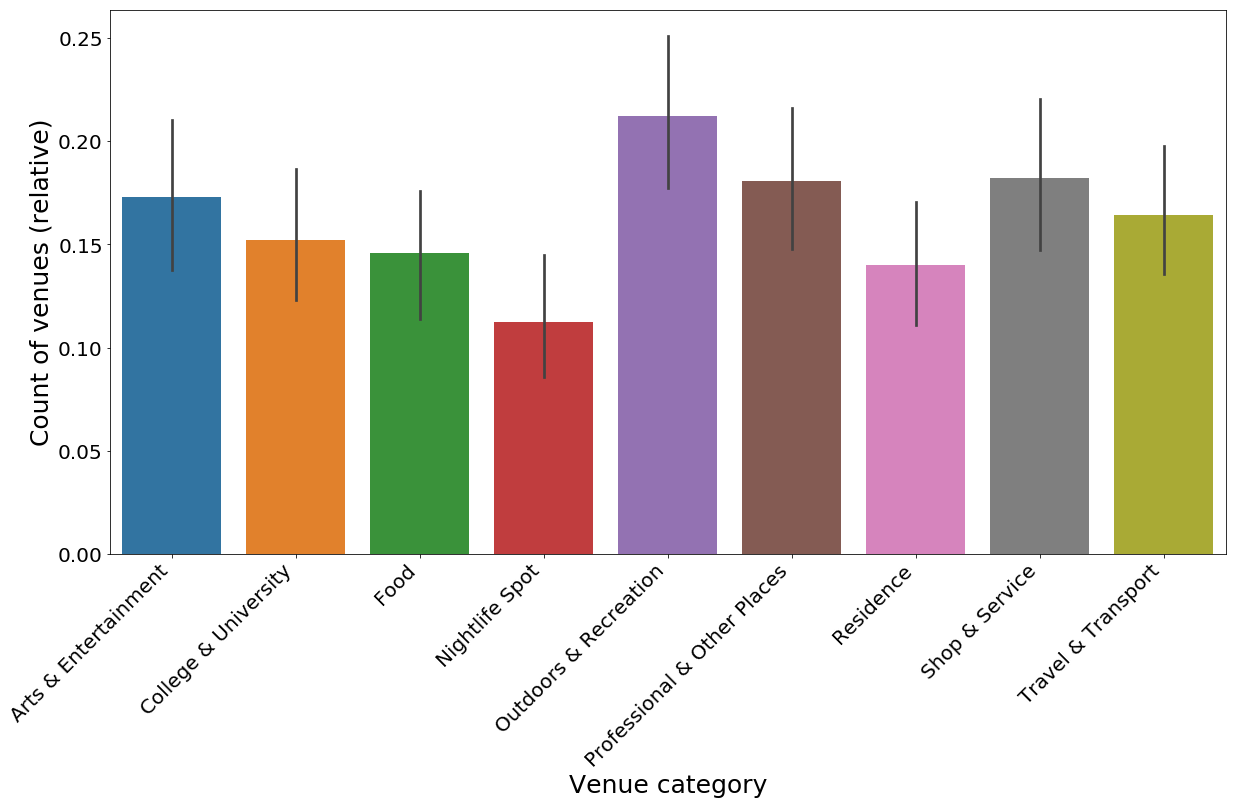

In [202]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.barplot

ax = sns.barplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = venues.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Station Name'] = stations_df['Station Name']
stations_clusters_minmax_df['Latitude'] = stations_df['Latitude']
stations_clusters_minmax_df['Longitude']=stations_df['Longitude']

c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


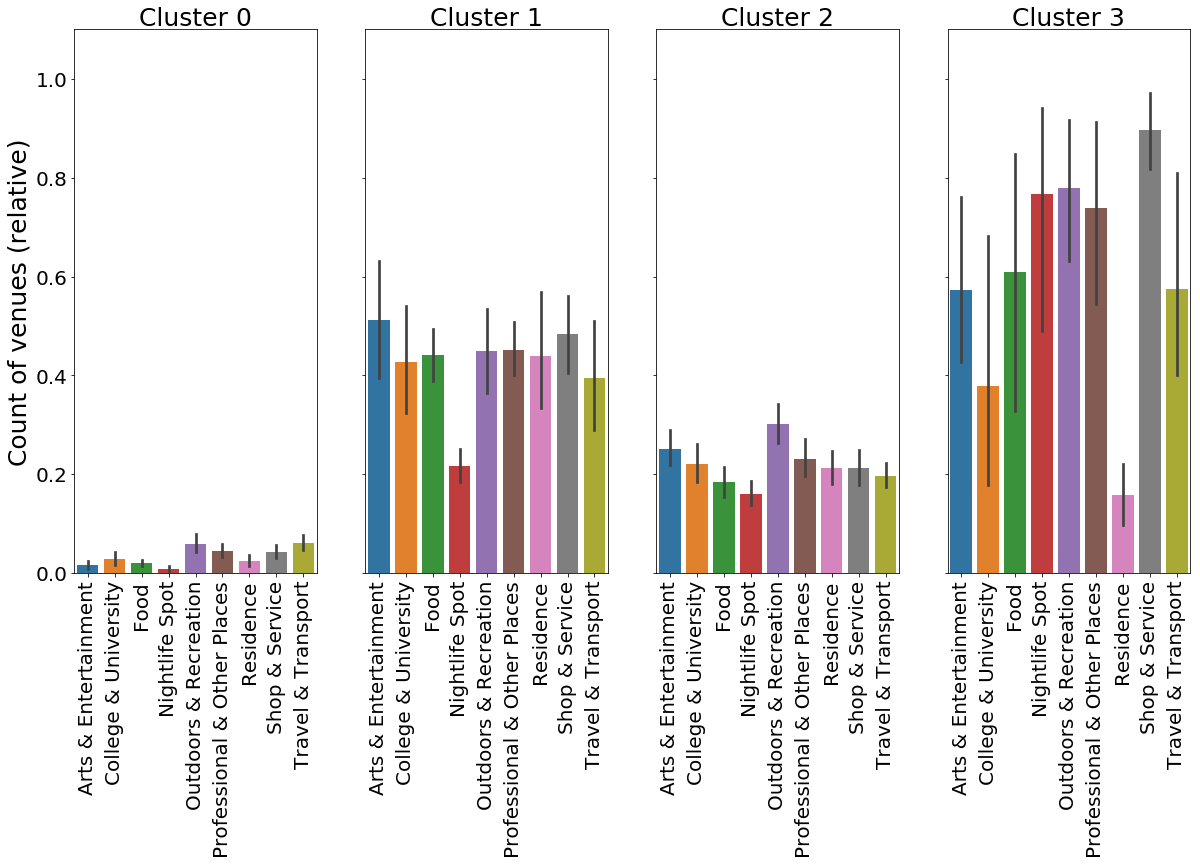

In [208]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.barplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [216]:
stations_clusters_minmax_df=stations_clusters_minmax_df.dropna()

In [219]:
stations_clusters_minmax_df.shape

(128, 13)

In [224]:
stations_clusters_minmax_df=stations_clusters_minmax_df.reset_index()

In [226]:
#create map of Mumbai with all stations
mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=10)

#add markers
for i, station, latitude,longitude, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['Station Name'],
                                         stations_clusters_minmax_df['Latitude'],stations_clusters_minmax_df['Longitude'],
                                         stations_clusters_minmax_df['Cluster']):
    colors=['blue','green','black','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker([latitude, longitude],fill=True,fill_opacity=0.5,popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster],
        fill_color=colors[cluster]
    ).add_to(mumbai_map)
    

In [227]:
mumbai_map

In [228]:
mumbai_map.save('Mumbai_Cluster_Map.html')